<a href="https://colab.research.google.com/github/carlibeisel/mason_water_budget/blob/main/drainflow_lagtime_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

By Carli Beisel

Created on August 20, 2024

Purpose: Superimpose all Mason Creek gauge readings to determine lag & response time of drain.

In [1]:
## --------------- ##
## IMPORT PACKAGES ##
## --------------- ##

import pandas as pd # to work with dataframe
import os # for file paths
import glob # read in a folder of csv
import numpy as np # basic statistics
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
## -------------------- ##
##  Mason Flow Files    ##
## -------------------- ##

phyllis = pd.read_csv('/content/drive/MyDrive/Data/Mason/mason_flow_response/mason_gauges/Mason Creek  at Phyllis.csv')

marble = pd.read_csv('/content/drive/MyDrive/Data/Mason/mason_flow_response/mason_gauges/Mason Creek Marble front Rd.csv')

madison = pd.read_csv('/content/drive/MyDrive/Data/Mason/mason_flow_response/mason_gauges/Mason Creek at Madison.csv')

northside = pd.read_csv('/content/drive/MyDrive/Data/Mason/mason_flow_response/mason_gauges/Mason Creek at Ustick and Northside.csv')

usgs = pd.read_csv('/content/drive/MyDrive/Data/Mason/mason_flow_response/mason_gauges/mason_usgs.csv')
usgs.rename(columns={
    'X_00060_00003': 'Flow',
    'Date': 'Time'
}, inplace=True)

In [3]:
# Function to create a new DataFrame with daily averages
def create_gauge_df(df, gauge_name, time_column='Time', flow_column='Flow'):
    df[time_column] = pd.to_datetime(df[time_column])
    df.set_index(time_column, inplace=True)
    df_daily = df.resample('D').mean()  # Resample by day and calculate the mean
    df_daily.reset_index(inplace=True)
    df_daily['Gauge'] = gauge_name
    df_daily = df_daily[['Gauge', time_column, flow_column]]
    df_daily.columns = ['Gauge', 'Date', 'Flow']  # Rename columns
    return df_daily

# Create a DataFrame for each gauge
phyllis_df = create_gauge_df(phyllis, 'Phyllis')
marble_df = create_gauge_df(marble, 'Marble')
madison_df = create_gauge_df(madison, 'Madison')
northside_df = create_gauge_df(northside, 'Northside')

# Combine all DataFrames into a single DataFrame
ethos_df = pd.concat([phyllis_df, marble_df, madison_df, northside_df])

In [9]:
## -------------------- ##
##  Mason USGS Gauge    ##
## -------------------- ##

# Prepare the USGS DataFrame similarly
usgs = pd.read_csv('/content/drive/MyDrive/Data/Mason/mason_flow_response/mason_gauges/mason_usgs.csv')
usgs.rename(columns={'X_00060_00003': 'Flow'}, inplace=True)

# Remove time from the Date column
usgs['Gauge'] = 'USGS'
usgs['Date'] = pd.to_datetime(usgs['Date']).dt.date

# Remove time from the Date column
ethos_df['Date'] = pd.to_datetime(ethos_df['Date']).dt.date

# Concatenate the USGS + ethos gauge dfs
final_df = pd.concat([ethos_df, usgs])
final_df.to_csv('final_df.csv', index=False)

In [10]:
final_df

,Gauge,Date,Flow,Unnamed: 0,agency_cd,site_no,X_00060_00003_cd,DiversionName
0,Phyllis,2024-05-20,31.666667,NaN,NaN,NaN,NaN,NaN
1,Phyllis,2024-05-21,32.180952,NaN,NaN,NaN,NaN,NaN
2,Phyllis,2024-05-22,33.854545,NaN,NaN,NaN,NaN,NaN
3,Phyllis,2024-05-23,31.401429,NaN,NaN,NaN,NaN,NaN
4,Phyllis,2024-05-24,32.800000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
137,USGS,2024-08-15,137.000000,138.0,USGS,13210980.0,P,MASON CREEK AT CALDWELL ID
138,USGS,2024-08-16,139.000000,139.0,USGS,13210980.0,P,MASON CREEK AT CALDWELL ID
139,USGS,2024-08-17,147.000000,140.0,USGS,13210980.0,P,MASON CREEK AT CALDWELL ID
140,USGS,2024-08-18,148.000000,141.0,USGS,13210980.0,P,MASON CREEK AT CALDWELL ID


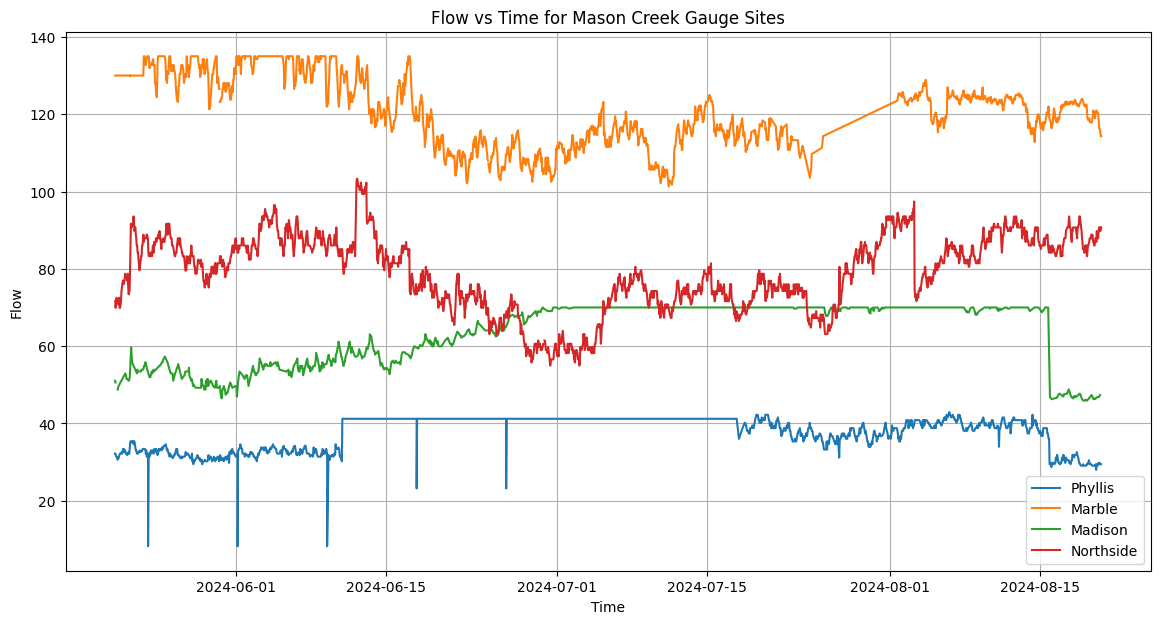

In [ ]:
## -------------------- ##
##  Superimposed Plot   ##
## -------------------- ##

# (Ethos Gauges only)

# Function to prepare data (convert 'Time' to datetime and set as index)
def prepare_data(df, time_column='Time', flow_column='Flow'):
    df[time_column] = pd.to_datetime(df[time_column], errors='coerce')
    df.set_index(time_column, inplace=True)
    return df[[flow_column]]

# Prepare each dataset
phyllis_prepared = prepare_data(phyllis)
marble_prepared = prepare_data(marble)
madison_prepared = prepare_data(madison)
northside_prepared = prepare_data(northside)

plt.figure(figsize=(14, 7))

plt.plot(phyllis_prepared, label='Mason at Phyllis')
plt.plot(marble_prepared, label='Mason at Marble')
plt.plot(madison_prepared, label='Mason at Madison')
plt.plot(northside_prepared, label='Mason at Northside')

plt.title('Flow vs Time for Mason Creek Gauge Sites')
plt.xlabel('Time')
plt.ylabel('Flow')
plt.legend()
plt.grid(True)

plt.show()

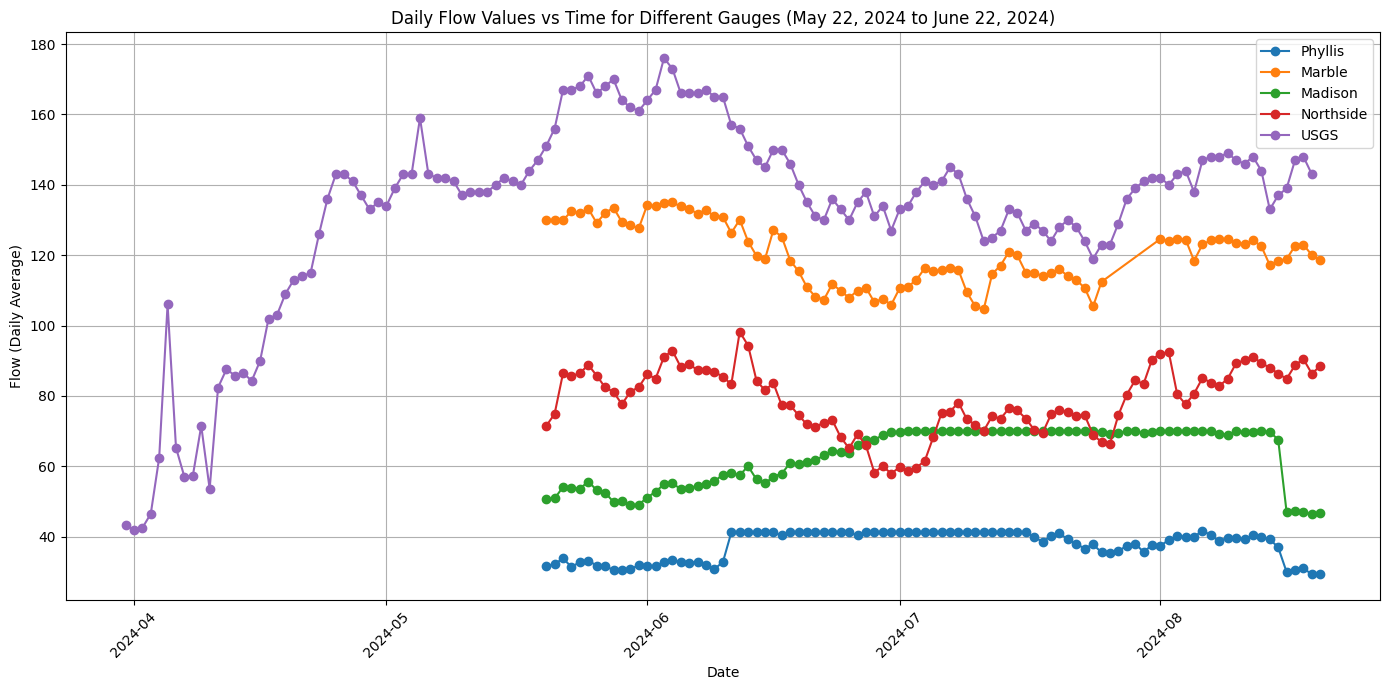

In [23]:
## ---------------------------------- ##
##  Superimposed Plot of Daily Data   ##
## ---------------------------------- ##
df = pd.read_csv('/content/final_df.csv')

# Convert the Date column to datetime format
date_column_name = 'Date'
df[date_column_name] = pd.to_datetime(df[date_column_name], errors='coerce')
df['Flow'] = pd.to_numeric(df['Flow'], errors='coerce')
df.dropna(subset=[date_column_name, 'Flow'], inplace=True)

start_date = '2024-05-22'
end_date = '2024-06-22'
filtered_df = df[(df[date_column_name] >= start_date) & (df[date_column_name] <= end_date)]

# Plotting
plt.figure(figsize=(14, 7))

for gauge in df['Gauge'].unique():
    gauge_data = df[df['Gauge'] == gauge]
    plt.plot(gauge_data[date_column_name], gauge_data['Flow'], marker='o', label=gauge)

plt.title('Daily Flow Values vs Time for Different Gauges (May 22, 2024 to June 22, 2024)')
plt.xlabel('Date')
plt.ylabel('Flow (Daily Average)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [ ]:
## -------------------- ##
##  Superimposed Plot   ##
## -------------------- ##

# (Ethos Gauges only)



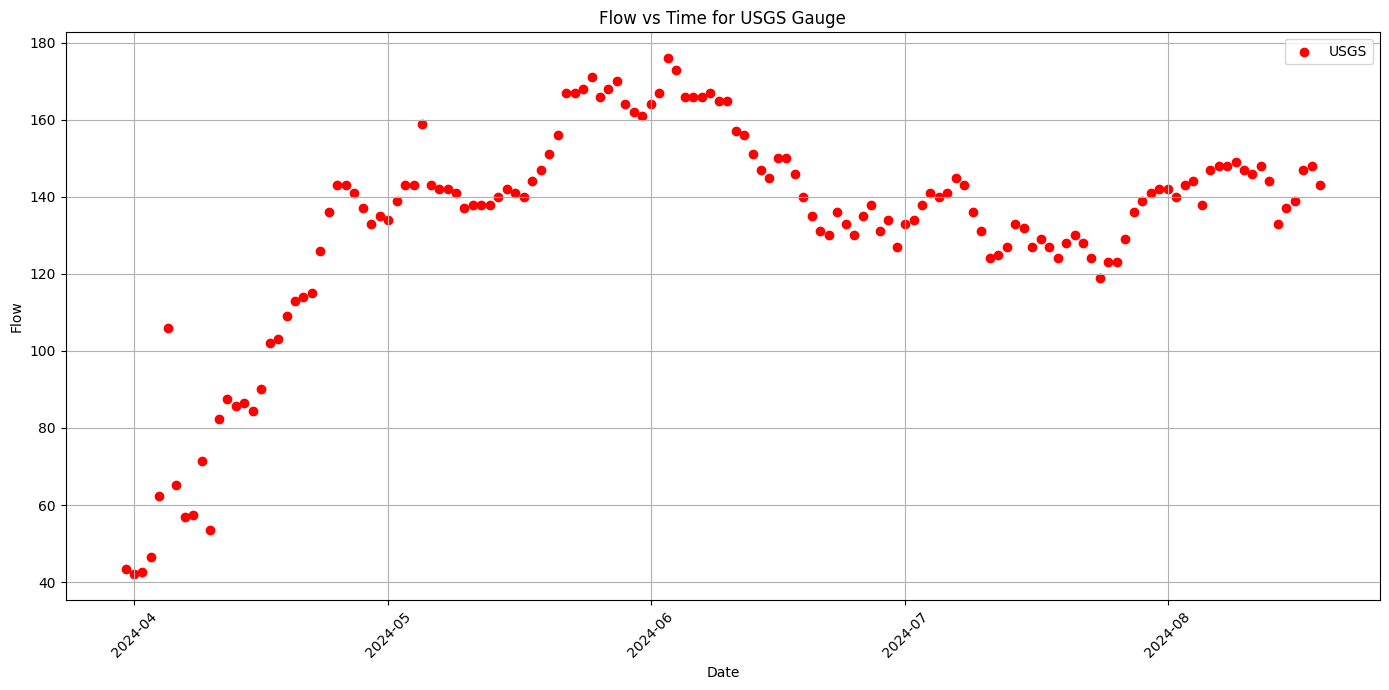

In [ ]:
# Scatter plot of USGS data
plt.figure(figsize=(14, 7))
plt.scatter(usgs['Date'], usgs['Flow'], color='r', marker='o', label='USGS')

plt.title('Flow vs Time for USGS Gauge')
plt.xlabel('Date')
plt.ylabel('Flow')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()